### 결측 방법 요약
1. MNAR
- Garage, Basement, Masonry 변수들의 경우 결측에 서로 연관이 있는 것으로 보인다. 하지만, 각 변수들의 Description에는 결측값은 해당 값이 실제로 없다는 것을 의미하기 때문에 수치형 변수는 0으로 범주형 변수는 "NA"로 대체하였다.

2. MCAR
- 그 외, 결측 값이 있는 변수들은 연관이 있는 다른 변수들과 비교해 볼 때 실제 값이 존재하지만 무작위로 결측된 것으로 보인다.

    - 대부분 결측 값을 가진 변수는 합리적인 접근법을 통해 연관이 있는 변수들의 데이터를 추출하여 평균 및 최빈 값으로 대체하였다.

    - GarageYrBlt의 경우 YearBuilt의 값과 굉장히 유사한 형태를 보인다. 따라서 GarageYrBlt - YearBuilt 의 중앙 값인 0으로 대체하였다.

        - 추가적으로 GarageYrBlt - YearBuilt에서 이상치가 존재하는 것으로 보인다. 이상치 탐색에서 재검토해야 될 것으로 보인다.

    - MasVnrType의 결측 비율은 60.50 % 으로 상당히 많이 존재

        - 차선책으로 최빈 값인 "BrkFace"으로 대체하였으나 모델의 성능과 잔차를 비교한 후, 결측 대체 방법을 다시 고민하기로 결정

    - LotFrontAge 변수는 **집에서 근처 지역 및 건물까지의 거리**를 뜻한다. 따라서 해당 변수는 Neighborhood 변수와 가장 관련이 있을 것이라 판단했기 때문에 Neighborhood 변수를 활용하여 결측 값을 중앙 값으로 대체하였다.

        - 중앙 대체방법은 LotFrontAge의 결측 비율이 16.65%이기 때문에 큰 편향이 존재할 수 있다. 따라서 모델의 성능을 보면서 결측 방법에 대해 다시 고민해 봐야 될 것 같다.


In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import random
import missingno as misno
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [2]:
path = 'C:\\Users\\이찬영\\Desktop\\House_Price\\'
train = pd.read_csv(path + 'train.csv',index_col='Id')
test = pd.read_csv(path + 'test.csv',index_col='Id')

### Train + Test 합치기

In [3]:
X = train.drop(columns = ['SalePrice'])
y = train.SalePrice

Full = pd.concat([X,test],axis=0)

train_idx = [i for i in range(1,1461)]
test_idx = [i for i in range(1461,2920)]

# Table shape
n_rows = Full.shape[0]
n_cols = Full.shape[1]
Full.shape

(2919, 79)

### 컬럼별 결측치 비율 확인

In [4]:
missing_val_count_by_column = pd.DataFrame(Full.isnull().sum(),columns=['col_n_missing'])
missing_val_count_by_column['col_perc_missing'] = round(100*(missing_val_count_by_column.col_n_missing/n_rows),2)
missing_val_count_by_column['type'] = [Full[c].dtype for c in missing_val_count_by_column.index]
missing_val_count_by_column[missing_val_count_by_column.col_perc_missing > 0.0].sort_values(by=['col_perc_missing'],ascending=False)

,col_n_missing,col_perc_missing,type
PoolQC,2909,99.66,object
MiscFeature,2814,96.40,object
Alley,2721,93.22,object
Fence,2348,80.44,object
MasVnrType,1766,60.50,object
FireplaceQu,1420,48.65,object
LotFrontage,486,16.65,float64
GarageFinish,159,5.45,object
GarageQual,159,5.45,object
GarageCond,159,5.45,object


In [6]:
cols_complete = missing_val_count_by_column[missing_val_count_by_column.col_perc_missing == 0.0].index
cols_num_w_missing = missing_val_count_by_column.loc[(missing_val_count_by_column.col_perc_missing > 0.0) & (missing_val_count_by_column.type != 'object')].index
cols_cat_w_missing = missing_val_count_by_column.loc[(missing_val_count_by_column.col_perc_missing > 0.0) & (missing_val_count_by_column.type == 'object')].index

### Garage
- Garage의 변수들 중 GarageType 변수에서 결측값이 있는 경우, No Garage로 작성되어 있으며 다른 Garage 변수에서도 동일하게 결측값으로 157개의 데이터가 동일하게 존재하지 않기 때문에 Garage가 없다고 판단. (MNAR 가정)

    - GarageCars와 GarageArea 변수들은 157개의 데이터에서 0의 값을 가지고 있기 때문에 Garage가 없다는 사실을 추가적으로 확인

    - 따라서 GarageType에 결측치가 있는 값은 Garage관련 수치형 변수를 0, 범주형 변수를 NA로 대체

- 이후 Garage 변수에서 결측값이 있는 행의 개수가 2개로 적은 양을 가지고 있기 때문에 어떤 결측의 유형인지 판단하기 어렵지만, 결측의 개수가 적은만큼 MCAR로 가정하기로 결정

    - 결측값이 존재하는 Garage 변수의 경우, 다른 독립변수들(Features)과의 관계도 존재하기 때문에 대체방법을 사용하기로 결정

#### MNAR

In [7]:
garage_cols = [col for col in Full.columns if col.find('Garage') > -1]
pd.DataFrame(Full[garage_cols].isnull().sum(),columns=['number']).sort_values(by='number', ascending=False)

,number
GarageYrBlt,159
GarageFinish,159
GarageQual,159
GarageCond,159
GarageType,157
GarageCars,1
GarageArea,1


In [8]:
garage_cat_cols = [col for col in cols_cat_w_missing if col.find('Garage') > -1]
garage_num_cols = [col for col in cols_num_w_missing if col.find('Garage') > -1]
garage_missing_index = Full[garage_cols].loc[(Full.GarageType.isnull() == True) &
                                             (Full.GarageFinish.isnull() == True) &
                                             (Full.GarageQual.isnull() == True) &
                                             (Full.GarageCond.isnull() == True) &
                                             (Full.GarageCars == 0) &
                                             (Full.GarageArea == 0)
                                             ].index

In [9]:
# 범주형
Full.loc[garage_missing_index, garage_cat_cols] = Full.loc[garage_missing_index, garage_cat_cols].fillna(value = 'Missing')

# 수치형
Full.loc[garage_missing_index, garage_num_cols] = Full.loc[garage_missing_index, garage_num_cols].fillna(value = 0)

#### MCAR

- 두 관측 값에서 GarageYrBlt & GarageFinish & GarageQual & GarageCond 변수가 동일하게 결측되어있다.

- GarageType에 값이 있고, 특히 2127은 GarageCars와 GarageArea에 값이 있으므로 무작위로 결측되었을 것이다.

In [10]:
Full[garage_cols].loc[(Full.GarageYrBlt.isnull() == True)]

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
Id,,,,,,,
2127,Detchd,NaN,NaN,1.0,360.0,NaN,NaN
2577,Detchd,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
aux_cols = garage_cat_cols + garage_num_cols + ['YearBuilt','YearRemodAdd','OverallQual','OverallCond','LotArea','BldgType']

- GarageYrBlt

    - GarageYrBlt와 YearBuilt는 거의 비슷한 시기에 지어졌을 확률이 크기 때문에 두 값은 거의 유사할 것이다.

        - 기술통계량 결과, 두 차이의 중앙값이 0이므로 GarageYrBlt 결측 값을 YearBuilt 값으로 대체하기로 결정하였다.

        - 또한 두 차이의 max 값이 201인 것으로 보아 해당 값은 이상치로 판단되며, 이상치 탐색할 때 자세히 살펴보기로 하였다.

In [12]:
yrblt_notmissing_index = Full[aux_cols].loc[(Full.GarageType != 'NA') & (Full.GarageYrBlt.isnull() == False)].index
yrblt = Full.loc[yrblt_notmissing_index,aux_cols]
yrblt['years_after_built'] = yrblt.GarageYrBlt - yrblt.YearBuilt
yrblt['years_before_remod'] = yrblt.YearRemodAdd - yrblt.GarageYrBlt
aux_df=yrblt.years_after_built
aux_df.describe()

count    2917.000000
mean      -99.703805
std       440.367944
min     -2007.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       201.000000
Name: years_after_built, dtype: float64

In [13]:
finish_notmissing_index = Full[aux_cols].loc[(Full.GarageType != 'NA') & (Full.GarageFinish.isnull() == False) & (Full.GarageType == 'Detchd') & (Full.OverallQual > 4) & (Full.OverallQual < 7)].index
finish = Full.loc[finish_notmissing_index,aux_cols]

- GarageFinish & GarageQual & GarageCond

    - 결측 값을 가지고 있는 데이터와 유사하게 만들어주기 위해 GarageType == "Detchd" 인 값들과 4 < OverallQual < 7 인 값들을 추출한 후, 세 개의 변수 값들을 각 최빈 값으로 대체하기로 결정하였다.

In [14]:
finish.GarageFinish.value_counts()

GarageFinish
Unf    518
Fin     17
RFn     14
Name: count, dtype: int64

In [15]:
finish.GarageQual.value_counts()

GarageQual
TA    479
Fa     60
Po      4
Gd      4
Ex      2
Name: count, dtype: int64

In [16]:
finish.GarageCond.value_counts()

GarageCond
TA    495
Fa     40
Po      9
Ex      3
Gd      2
Name: count, dtype: int64

In [17]:
area_missing_index = Full[aux_cols].loc[(Full.GarageType != 'NA') & (Full.GarageArea.isnull() == True)].index
Full.loc[area_missing_index,aux_cols]

,GarageType,GarageFinish,GarageQual,GarageCond,GarageYrBlt,GarageCars,GarageArea,YearBuilt,YearRemodAdd,OverallQual,OverallCond,LotArea,BldgType
Id,,,,,,,,,,,,,
2577,Detchd,NaN,NaN,NaN,NaN,NaN,NaN,1923,1999,5,6,9060,1Fam


- GarageArea & GarageCars

    - GarageArea 와 GarageCars는 면적과 관련이 있으므로 LotArea와 BldgType와 밀접한 관련이 있을 것이라 생각하였다. 따라서 GarageArea & GarageCars과 유사한 두 변수들을 추출하여 결측 값을 대체하기로 결정하였다.

In [18]:
area_notmissing_index = Full[aux_cols].loc[(Full.GarageType != 'NA') & (Full.GarageArea.isnull() == False) & (Full.GarageType == 'Detchd') & (Full.LotArea < 10000) & (Full.BldgType == '1Fam')].index
area = Full.loc[area_notmissing_index,aux_cols]

<Axes: xlabel='LotArea', ylabel='GarageArea'>

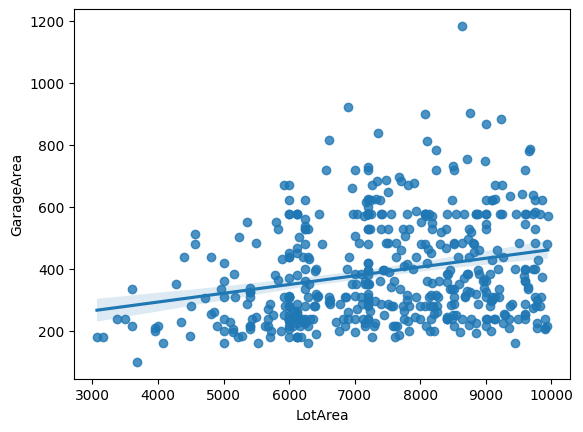

In [19]:
sns.regplot(x=area['LotArea'], y=area['GarageArea'])

In [20]:
area['GarageArea'].describe()

count     484.000000
mean      390.623967
std       167.421138
min       100.000000
25%       250.000000
50%       347.000000
75%       528.000000
max      1184.000000
Name: GarageArea, dtype: float64

In [21]:
area.GarageCars.value_counts()

GarageCars
1.0    287
2.0    191
3.0      4
4.0      1
5.0      1
Name: count, dtype: int64

### Basement
- Basement의 변수들 중 BsmtFinType1 변수에서 결측값이 있는 경우, No Basement로 작성되어 있으며 다른 Basement 변수에서도 결측이 79개 이상의 데이터가 존재하지 않기 때문에 Basement가 없다고 판단. (MNAR 가정)

    - Basement의 관련있는 BsmtFinSF, BsmtUnfSF, TotalBsmtSF 변수들은 0의 값을 가질 때 Basement가 없다는 사실을 추가적으로 확인

    - 따라서 BsmtFinType1에 결측치가 있는 값은 Basement관련 수치형 변수를 0, 범주형 변수를 NA로 대체
    
    - Basement가 존재할 것이라고 가정하는 데이터들 중, 서로 다른 행의 결측값을 가지고 있으며 결측의 비율이 적으므로 MCAR이라 가정
        
        - BsmtCond: 3, BsmtExposure: 3, BsmtQual: 2, BsmtFinType2: 1


#### MNAR

In [22]:
bsmt_cols = [col for col in Full.columns if col.find('Bsmt') > -1]
pd.DataFrame(Full[bsmt_cols].isnull().sum(),columns=['number']).sort_values(by='number', ascending=False)

,number
BsmtCond,82
BsmtExposure,82
BsmtQual,81
BsmtFinType2,80
BsmtFinType1,79
BsmtFullBath,2
BsmtHalfBath,2
BsmtFinSF1,1
BsmtFinSF2,1
BsmtUnfSF,1


In [23]:
bsmt_cat_cols = [col for col in cols_cat_w_missing if col.find('Bsmt') > -1] # 범주형인 지하실 관련 변수 이름 추출
bsmt_num_cols = [col for col in cols_num_w_missing if col.find('Bsmt') > -1] # 수치형인 지하실 관련 변수 이름 추출

bsmt_missing_index = Full[bsmt_cols].loc[(Full.BsmtExposure.isnull() == True) & 
                    (Full.BsmtCond.isnull() == True) &
                    (Full.BsmtQual.isnull() == True) &
                    (Full.BsmtFinType1.isnull() == True) &
                    (Full.BsmtFinType2.isnull() == True) |
                    (Full.BsmtFinSF1.isnull() == True) |
                    (Full.BsmtFullBath.isnull() == True) |
                    (Full.BsmtHalfBath.isnull() == True) |
                    (Full.BsmtUnfSF.isnull() == True) |
                    (Full.BsmtFinSF2.isnull() == True) |
                    (Full.TotalBsmtSF.isnull() == True)
                   ].index
Full.loc[bsmt_missing_index,bsmt_cat_cols] = Full.loc[bsmt_missing_index,bsmt_cat_cols].fillna(value='Missing')
Full.loc[bsmt_missing_index,bsmt_num_cols] = Full.loc[bsmt_missing_index,bsmt_num_cols].fillna(value=0)

#### MCAR

In [24]:
pd.DataFrame(Full[bsmt_cols].isnull().sum(),columns=['number']).sort_values(by='number', ascending=False)

,number
BsmtCond,3
BsmtExposure,3
BsmtQual,2
BsmtFinType2,1
BsmtFinType1,0
BsmtFinSF1,0
BsmtFinSF2,0
BsmtUnfSF,0
TotalBsmtSF,0
BsmtFullBath,0


- BsmtCond

    - 지하실의 전반적인 형태는 집의 전반적인 형태와 유사할 것이다.

In [25]:
aux_cols = bsmt_cat_cols + bsmt_num_cols + ['OverallQual','OverallCond']
bsmt_missing_index = Full[aux_cols].loc[(Full.BsmtCond.isnull() == True)].index
Full.loc[bsmt_missing_index,aux_cols]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,OverallQual,OverallCond
Id,,,,,,,,,,,,,
2041,Gd,NaN,Mn,GLQ,Rec,1044.0,382.0,0.0,1426.0,1.0,0.0,8,9
2186,TA,NaN,No,BLQ,Unf,1033.0,0.0,94.0,1127.0,0.0,1.0,6,6
2525,TA,NaN,Av,ALQ,Unf,755.0,0.0,240.0,995.0,0.0,0.0,5,7


In [26]:
bsmt_notmissing_index = Full[aux_cols].loc[(Full.BsmtCond.isnull() == False) & (Full.OverallCond > 5) & (Full.OverallCond < 10)].index
cond = Full.loc[bsmt_notmissing_index,aux_cols]

In [27]:
cond.BsmtCond.value_counts()

BsmtCond
TA         985
Gd          48
Fa          43
Missing     25
Po           2
Name: count, dtype: int64

- BsmtExposure

    - BsmtExposure 변수의 결측 값은 BsmtQual & BsmtCond & BsmtFinType1 의 값과 굉장히 유사할 것으로 판단

In [28]:
bsmt_missing_index = Full[aux_cols].loc[(Full.BsmtExposure.isnull() == True)].index
Full.loc[bsmt_missing_index,aux_cols]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,OverallQual,OverallCond
Id,,,,,,,,,,,,,
949,Gd,TA,NaN,Unf,Unf,0.0,0.0,936.0,936.0,0.0,0.0,7,5
1488,Gd,TA,NaN,Unf,Unf,0.0,0.0,1595.0,1595.0,0.0,0.0,8,5
2349,Gd,TA,NaN,Unf,Unf,0.0,0.0,725.0,725.0,0.0,0.0,5,5


In [29]:
bsmt_notmissing_index = Full[aux_cols].loc[(Full.BsmtExposure.isnull() == False) & (Full.BsmtExposure != 'NA') & (Full.BsmtQual == 'Gd') & (Full.BsmtCond == 'TA') & (Full.BsmtFinType1 == 'Unf')].index
cond = Full.loc[bsmt_notmissing_index,aux_cols]

In [30]:
cond.BsmtExposure.value_counts()

BsmtExposure
No    255
Av     58
Mn     22
Gd     10
Name: count, dtype: int64

- BsmtQual

    - BsmtQual은 OverallQual 값과 관련이 있을 것이다.

In [31]:
bsmt_missing_index = Full[aux_cols].loc[(Full.BsmtQual.isnull() == True)].index
Full.loc[bsmt_missing_index,aux_cols]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,OverallQual,OverallCond
Id,,,,,,,,,,,,,
2218,NaN,Fa,No,Unf,Unf,0.0,0.0,173.0,173.0,0.0,0.0,4,7
2219,NaN,TA,No,Unf,Unf,0.0,0.0,356.0,356.0,0.0,0.0,4,7


In [32]:
bsmt_notmissing_index = Full[aux_cols].loc[(Full.BsmtQual.isnull() == False) & (Full.BsmtQual != 'NA') & (Full.OverallQual >= 3) & (Full.OverallQual <= 5)].index
cond = Full.loc[bsmt_notmissing_index,aux_cols]

In [33]:
cond.BsmtQual.value_counts()

BsmtQual
TA         776
Gd         179
Missing     67
Fa          63
Ex           4
Name: count, dtype: int64

- BsmtFinType2

    - 333 은 497 값과 유사하므로 BsmtFinType2 값은 Unf으로 대체하기로 결정하였다.

In [34]:
bsmt_missing_index = Full[aux_cols].loc[(Full.BsmtFinType2.isnull() == True)].index
Full.loc[bsmt_missing_index,aux_cols]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,OverallQual,OverallCond
Id,,,,,,,,,,,,,
333,Gd,TA,No,GLQ,NaN,1124.0,479.0,1603.0,3206.0,1.0,0.0,8,5


In [35]:
bsmt_notmissing_index = Full[aux_cols].loc[(Full.BsmtFinType2.isnull() == False) & (Full.BsmtFinType2 != 'NA') & (Full.TotalBsmtSF < 3400) & (Full.TotalBsmtSF > 3000)].index
cond = Full.loc[bsmt_notmissing_index,aux_cols]

In [36]:
cond

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,OverallQual,OverallCond
Id,,,,,,,,,,,,,
441,Ex,TA,Gd,GLQ,ALQ,1767.0,539.0,788.0,3094.0,1.0,0.0,10,5
497,Gd,TA,No,GLQ,Unf,1231.0,0.0,1969.0,3200.0,1.0,0.0,8,5
524,Ex,TA,Gd,GLQ,Unf,2260.0,0.0,878.0,3138.0,1.0,0.0,10,5


### Masonry
- Masonry veneer의 경우, MasVnrType에서 결측치가 있으면 해당 집에 Masonry가 없다고 간주될 수 있음. (MNAR)

    - MasVnrType의 결측 비율은 60.50 % 으로 상당히 많이 존재

        - 차선책으로 최빈 값인 "BrkFace"으로 대체하였으나 모델의 성능과 잔차를 비교한 후, 결측 대체 방법을 다시 고민하기로 결정
    
    - MasVnrType에 결측치가 있을 때, MasVnrArea에서도 결측치가 23개 존재하기 때문에 0으로 대체

#### MNAR

In [37]:
masvnr_cat_cols = [col for col in cols_cat_w_missing if col.find('MasVnr') > -1]
masvnr_num_cols = [col for col in cols_num_w_missing if col.find('MasVnr') > -1]
masvnr_missing_index = Full[['MasVnrArea','MasVnrType']].loc[(Full.MasVnrType.isnull() == True) &
                                      (Full.MasVnrArea.isnull() == True)
                                     ].index
Full.loc[masvnr_missing_index,masvnr_cat_cols] = Full.loc[masvnr_missing_index,masvnr_cat_cols].fillna(value='NA')
Full.loc[masvnr_missing_index,masvnr_num_cols] = Full.loc[masvnr_missing_index,masvnr_num_cols].fillna(value=0)

In [38]:
aux_cols = masvnr_cat_cols + masvnr_num_cols + ['ExterQual', 'ExterCond']
vnr_missing_index = Full[aux_cols].loc[(Full.MasVnrType.isnull() == True)].index
Full.loc[vnr_missing_index,aux_cols]

,MasVnrType,MasVnrArea,ExterQual,ExterCond
Id,,,,
2,NaN,0.0,TA,TA
4,NaN,0.0,TA,TA
6,NaN,0.0,TA,TA
9,NaN,0.0,TA,TA
10,NaN,0.0,TA,TA
...,...,...,...,...
2914,NaN,0.0,TA,TA
2915,NaN,0.0,TA,TA
2916,NaN,0.0,TA,TA


In [39]:
vnr_notmissing_index = Full[aux_cols].loc[(Full.MasVnrType.isnull() == False) & (Full.MasVnrType != 'NA') & (Full.ExterQual == 'TA') & (Full.ExterCond == 'TA') & (Full.MasVnrArea > 0)].index
cond = Full.loc[vnr_notmissing_index,aux_cols]
cond

,MasVnrType,MasVnrArea,ExterQual,ExterCond
Id,,,,
8,Stone,240.0,TA,TA
15,BrkFace,212.0,TA,TA
17,BrkFace,180.0,TA,TA
38,BrkFace,650.0,TA,TA
41,BrkFace,101.0,TA,TA
...,...,...,...,...
2870,BrkFace,60.0,TA,TA
2891,BrkFace,327.0,TA,TA
2900,BrkFace,257.0,TA,TA


In [40]:
cond.MasVnrType.value_counts()

MasVnrType
BrkFace    388
Stone       44
BrkCmn      18
Name: count, dtype: int64

### MSZoning
- MSZoning 변수의 경우 결측치가 3개로 적은 수에 속하기 때문에 MCAR로 가정하기로 결정

- 또한, MSZoning 변수는 Neighborhood 변수와 관련이 있는 것을 확인. 그 외 변수들과도 관련이 존재할 수 있기 때문에 머신러닝 모델을 활용하여 결측값을 대체하기로 결정

    - Neighborhood = "IDOTRR" 일 때, MSZoning의 값은 RM(68)과 C(22)로 집계

    - Neighborhood = "Mitchel" 일 때, MSZoning의 값은 RL(104)과 RM(9)으로 집계

In [41]:
cols = ['MSZoning','Neighborhood']
missing_index = Full[cols].loc[(Full.MSZoning.isnull() == True)].index
Full.loc[missing_index,cols]

,MSZoning,Neighborhood
Id,,
1916,NaN,IDOTRR
2217,NaN,IDOTRR
2251,NaN,IDOTRR
2905,NaN,Mitchel


In [42]:
IDOTRR_notmissing_index = Full[cols].loc[(Full.MSZoning.isnull() == False) & (Full.Neighborhood == 'IDOTRR')].index
IDOTRR = Full.loc[IDOTRR_notmissing_index,cols]
IDOTRR_count = IDOTRR.MSZoning.value_counts()
IDOTRR_count

MSZoning
RM         68
C (all)    22
Name: count, dtype: int64

In [43]:
Mitch_notmissing_index = Full[cols].loc[(Full.MSZoning.isnull() == False) & (Full.Neighborhood == 'Mitchel')].index
Mitch = Full.loc[Mitch_notmissing_index,cols]
Mitch_count = Mitch.MSZoning.value_counts()
Mitch_count

MSZoning
RL    104
RM      9
Name: count, dtype: int64

### Utilities
- Utilities 변수의 결측값은 2개의 행을 가지며, 99%의 확률로 "AllPub"의 값을 가지고 있다. 따라서 해당 변수를 MCAR로 가정하며, 최빈값으로 대체하기로 결정하였다.

In [44]:
cols = ['Utilities']
utl_missing_index = Full[cols].loc[(Full.Utilities.isnull() == True)].index
Full.loc[utl_missing_index,cols]

,Utilities
Id,
1916,NaN
1946,NaN


In [45]:
Full.Utilities.value_counts()

Utilities
AllPub    2916
NoSeWa       1
Name: count, dtype: int64

### 그 외 기타 변수들 (Functional, Exterior1st and Exterior2nd, Electrical, KitchenQual, SaleType)
- 모두 샘플 수가 적기 때문에 MCAR이라 가정 

- 따라서 위 방법들과 동일하게 최빈 값으로 결측 대체


In [46]:
aux_cols = ['Functional', 'Exterior1st', 'Exterior2nd' , 'Electrical', 'KitchenQual', 'SaleType', 'SaleCondition', 'Neighborhood']
sale_missing_index = Full[aux_cols].loc[(Full.Functional.isnull() == True) | (Full.Exterior1st.isnull() == True) | (Full.Exterior2nd.isnull() == True) | (Full.Electrical.isnull() == True) |
                                        (Full.KitchenQual.isnull() == True) | (Full.SaleType.isnull() == True) | (Full.SaleCondition.isnull() == True) | (Full.Neighborhood.isnull() == True)].index
Full.loc[sale_missing_index,aux_cols]

,Functional,Exterior1st,Exterior2nd,Electrical,KitchenQual,SaleType,SaleCondition,Neighborhood
Id,,,,,,,,
1380,Typ,VinylSd,VinylSd,NaN,Gd,WD,Normal,Timber
1556,Mod,Wd Sdng,Wd Sdng,SBrkr,NaN,COD,Normal,ClearCr
2152,Typ,NaN,NaN,SBrkr,Fa,WD,Normal,Edwards
2217,NaN,AsbShng,VinylSd,FuseA,Fa,WD,Abnorml,IDOTRR
2474,NaN,Wd Sdng,Wd Sdng,SBrkr,TA,COD,Abnorml,IDOTRR
2490,Typ,Plywood,Plywood,SBrkr,TA,NaN,Normal,Sawyer


In [47]:
aux_cols = ['Functional', 'Utilities','Neighborhood','OverallQual','OverallCond']
fun_missing_index = Full[aux_cols].loc[(Full.Functional.isnull() == True)].index
Full.loc[fun_missing_index,aux_cols]

,Functional,Utilities,Neighborhood,OverallQual,OverallCond
Id,,,,,
2217,NaN,AllPub,IDOTRR,1,5
2474,NaN,AllPub,IDOTRR,4,1


In [48]:
fun_notmissing_index = Full[aux_cols].loc[(Full.Functional.isnull() == False) ].index
cond = Full.loc[fun_notmissing_index,aux_cols]

In [49]:
cond.Functional.value_counts()

Functional
Typ     2717
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sev        2
Name: count, dtype: int64

In [50]:
aux_cols = ['Exterior1st', 'Exterior2nd','ExterQual', 'ExterCond','OverallQual','OverallCond', 'Neighborhood']
ext_missing_index = Full[aux_cols].loc[(Full.Exterior1st.isnull() == True)].index
Full.loc[ext_missing_index,aux_cols]

,Exterior1st,Exterior2nd,ExterQual,ExterCond,OverallQual,OverallCond,Neighborhood
Id,,,,,,,
2152,NaN,NaN,TA,TA,5,7,Edwards


In [51]:
ext_notmissing_index = Full[aux_cols].loc[(Full.Exterior1st.isnull() == False) & (Full.ExterQual == 'TA') & (Full.ExterCond == 'TA') & (Full.OverallQual > 4) & (Full.OverallQual < 6) & (Full.OverallCond > 6) & (Full.OverallCond < 8) & (Full.Neighborhood == 'Edwards')].index
cond = Full.loc[ext_notmissing_index,aux_cols]

In [52]:
cond.Exterior1st.value_counts()

Exterior1st
MetalSd    4
Wd Sdng    3
WdShing    3
Stucco     1
Plywood    1
Name: count, dtype: int64

In [53]:
cond.Exterior2nd.value_counts()

Exterior2nd
Wd Sdng    4
MetalSd    3
Plywood    2
Wd Shng    2
Stucco     1
Name: count, dtype: int64

In [54]:
aux_cols = ['Electrical','ExterQual', 'ExterCond','OverallQual','OverallCond', 'Neighborhood']
electrical_missing_index = Full[aux_cols].loc[(Full.Electrical.isnull() == True)].index
Full.loc[electrical_missing_index,aux_cols]

,Electrical,ExterQual,ExterCond,OverallQual,OverallCond,Neighborhood
Id,,,,,,
1380,NaN,TA,TA,5,5,Timber


In [55]:
electrical_notmissing_index = Full[aux_cols].loc[(Full.Electrical.isnull() == False)].index
cond = Full.loc[electrical_notmissing_index,aux_cols]

In [56]:
cond.Electrical.value_counts()

Electrical
SBrkr    2671
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: count, dtype: int64

In [57]:
aux_cols = ['KitchenQual','KitchenAbvGr','OverallQual']
kq_missing_index = Full[aux_cols].loc[(Full.KitchenQual.isnull() == True)].index
Full.loc[kq_missing_index,aux_cols]

,KitchenQual,KitchenAbvGr,OverallQual
Id,,,
1556,NaN,1,5


In [58]:
kq_notmissing_index = Full[aux_cols].loc[(Full.KitchenQual.isnull() == False) & (Full.KitchenAbvGr == 1) & (Full.OverallQual < 6)].index
cond = Full.loc[kq_notmissing_index,aux_cols]

In [59]:
cond.KitchenQual.value_counts()

KitchenQual
TA    796
Gd    147
Fa     50
Ex     15
Name: count, dtype: int64

In [60]:
aux_cols = ['SaleType','SaleCondition','Neighborhood']
sale_missing_index = Full[aux_cols].loc[(Full.SaleType.isnull() == True)].index
Full.loc[sale_missing_index,aux_cols]

,SaleType,SaleCondition,Neighborhood
Id,,,
2490,NaN,Normal,Sawyer


In [61]:
sale_notmissing_index = Full[aux_cols].loc[(Full.SaleType.isnull() == False) & (Full.SaleCondition == 'Normal')].index
cond = Full.loc[sale_notmissing_index,aux_cols]

In [62]:
cond.SaleType.value_counts()

SaleType
WD       2314
COD        39
ConLD      21
CWD        10
ConLw       7
ConLI       5
Con         4
Oth         1
Name: count, dtype: int64

### LotFrontAge
- LotFrontage 변수의 경우, 486개로 16.65%의 결측치가 존재 (MCAR)

- LotFrontage 변수의 의미는 **집에서 근처 지역 및 건물까지의 거리**를 뜻한다. 따라서 해당 변수는 Neighborhood 변수와 가장 관련이 있을 것이라 판단했기 때문에 Neighborhood 변수를 활용하여 결측 값을 대체하기로 결정하였다.

- Neighborhood의 LotFrontage 값은 이상치가 많이 존재하여 Neighborhood별 LotFrontage 값의 중앙값으로 대체하였다.

- 하지만, LotFrontage의 결측 값은 16.65%이기 때문에 중앙값으로 대체하기에는 큰 편향이 존재할 수 있다. 따라서 모델의 성능을 보면서 결측 방법에 대해 다시 고민해 봐야 될 것 같다.